In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fashionmnist:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2243%2F9243%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T164522Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4596022c60ea5b8a95e1546beb7d05ef75c1f6c4da9156eca38d1c3f243af51923cd92c99520af4899468d55f1629e91dbe0fce300e8c14381656d4e6c8fce3e6b257adcb091fa21eed315923aacd21688982c864ff920bd92e8e644e06ef2e469145b1ea66d31f1c4bb4480e63b28705e950ed79bd3b359dfc3aa0e39f0a13a4ee29e996b476e57278479c9b6bc8509d6126e35625631af9a3a862a682eb1af6e3be9321052a47047a8b551be797516f46901b64bbf9f262f46ad36b91d9e1e8cab5dbb544bad830bdb688c3fd09bbd3f31c23cd2f5b6440f6686504879a7f911149c87c5e1f21334275426487b7d4908a7d516f24078c76784a017534b194b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 72114846 bytes downloaded
Downloaded and uncompressed: fashionmnist
Data source import complete.


Labels shape: (60000,)


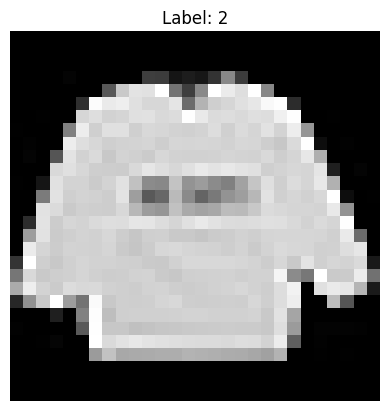

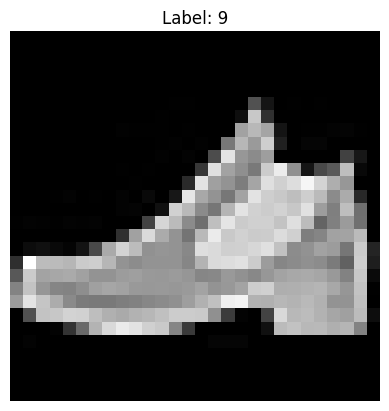

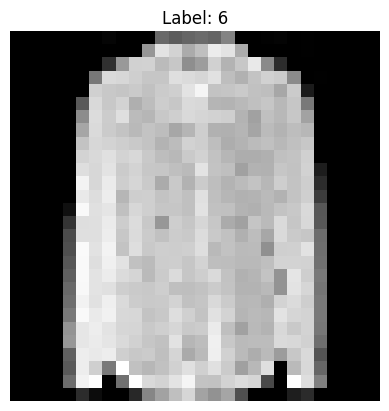

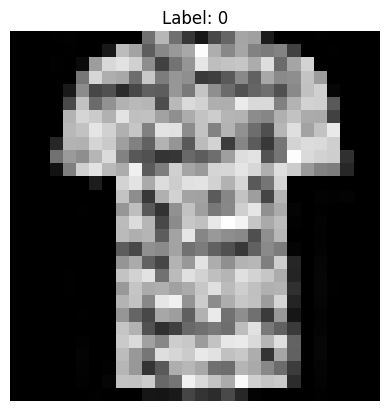

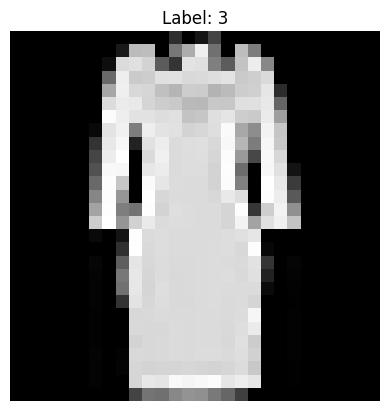

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')

pixels = train_data.iloc[:, 1:].values
labels = train_data.iloc[:, 0].values
print("Labels shape:", labels.shape)
def create_images(pixels):
    images = pixels.reshape(-1, 28, 28)
    return images


images = create_images(pixels)

num_images_to_visualize = 5
for i in range(num_images_to_visualize):
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')
    plt.show()


In [3]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 5 * 5, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        output_channels = self.conv2.out_channels
        #print("Output channels:", output_channels)
        #print("Shape of x before FC1:", x.shape)
        x = x.view(-1, 64 * 5 * 5)
        #print("Shape of weight matrix for FC1:", self.fc1.weight.shape)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:

images_tensor = torch.tensor(images, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.long)

print("Images tensor shape:", images_tensor.shape)
print("Labels tensor shape:", labels_tensor.shape)

dataset = TensorDataset(images_tensor, labels_tensor)

trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Images tensor shape: torch.Size([60000, 28, 28])
Labels tensor shape: torch.Size([60000])


In [6]:
print("Size of training dataset:", len(dataset))
batch_size = 64
print("Batch size:", batch_size)
num_iterations_per_epoch = len(dataset) // batch_size
print("Expected number of iterations per epoch:", num_iterations_per_epoch)

num_epochs = 5
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

Size of training dataset: 60000
Batch size: 64
Expected number of iterations per epoch: 937
[1,   100] loss: 2.245
[1,   200] loss: 0.570
[1,   300] loss: 0.517
[1,   400] loss: 0.476
[1,   500] loss: 0.453
[1,   600] loss: 0.429
[1,   700] loss: 0.422
[1,   800] loss: 0.390
[1,   900] loss: 0.408
[2,   100] loss: 0.379
[2,   200] loss: 0.376
[2,   300] loss: 0.373
[2,   400] loss: 0.373
[2,   500] loss: 0.347
[2,   600] loss: 0.352
[2,   700] loss: 0.358
[2,   800] loss: 0.322
[2,   900] loss: 0.345
[3,   100] loss: 0.287
[3,   200] loss: 0.311
[3,   300] loss: 0.310
[3,   400] loss: 0.311
[3,   500] loss: 0.312
[3,   600] loss: 0.304
[3,   700] loss: 0.308
[3,   800] loss: 0.322
[3,   900] loss: 0.314
[4,   100] loss: 0.262
[4,   200] loss: 0.286
[4,   300] loss: 0.271
[4,   400] loss: 0.274
[4,   500] loss: 0.275
[4,   600] loss: 0.286
[4,   700] loss: 0.287
[4,   800] loss: 0.293
[4,   900] loss: 0.287
[5,   100] loss: 0.258
[5,   200] loss: 0.247
[5,   300] loss: 0.257
[5,   400] 

In [7]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

test_labels = test_data.iloc[:, 0].values
pixels = test_data.iloc[:, 1:].values

def preprocess_test_data(pixels):
    images = pixels.reshape(-1, 28, 28)
    return images

test_images = preprocess_test_data(pixels)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32).to(device)

test_dataset = TensorDataset(test_images_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

predictions = []
with torch.no_grad():
    for images in test_loader:
        outputs = model(images[0].unsqueeze(1))
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().tolist())

correct_predictions = sum(pred == label for pred, label in zip(predictions, test_labels))


print("Number of correct predictions:", correct_predictions, " out of ", len(predictions))


Number of correct predictions: 8955  out of  10000
